https://stepik.org/lesson/1576189/step/9

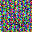

(32, 32)


In [ ]:
# @title Неправильная генерация объекта ds
import torch
import torch.utils.data as data
from PIL import Image # для тестовой картинки

ds = lambda: None # Создаем пустой объект
ds.data = torch.rand((256, 1, 32, 32)) * 256
ds.target = torch.randint(0, 2, (256,)).float()

# Проверка картинки
img_pil = Image.fromarray(ds.data[0][0].numpy(), 'RGB')
display(img_pil)
print(img_pil.size)

In [ ]:
# @title Генератор датасета
import torch.utils.data as data
import torch

class DatasetLike:
    def __init__(self):
        self.data = torch.rand((256, 1, 32, 32)) * 256
        self.target = torch.randint(0, 2, (256,)).float()

    def __getitem__(self, item):
        return self.data[item], self.target[item]

    def __len__(self):
        return len(self.data)

ds = DatasetLike()

# Доступ к данным
print(ds.data.shape, ds.target.shape)

torch.Size([256, 1, 32, 32]) torch.Size([256])


In [ ]:
# @title Решение
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from tqdm import tqdm


d_train, d_test = data.random_split(ds, [0.7, 0.3])

train_data = data.DataLoader(d_train, batch_size=16, shuffle=True)
test_data = data.DataLoader(d_test, batch_size=len(d_test), shuffle=False)

model = nn.Sequential(
    # Вход: (batch_size, 1, 32, 32)
    nn.Conv2d(1, 32, (5, 5), stride=1, padding=2, bias=True),   # (batch_size, 32, 32, 32)
    nn.ReLU(inplace=True),
    nn.MaxPool2d((2, 2), stride=2),                             # (batch_size, 32, 16, 16)
    nn.Conv2d(32, 16, (3, 3), stride=1, padding=1, bias=True),  # (batch_size, 16, 16, 16)
    nn.ReLU(inplace=True),
    nn.MaxPool2d((2, 2), stride=2),                             # (batch_size, 16, 8, 8)
    nn.Flatten(),                                               # (batch_size, 16 * 8 * 8)
    nn.Linear(16 * 8 * 8, 1, bias=True)                         # (batch_size, 16 * 8 * 8 = 1024)
)

model.train()

# Параметры обучения
epochs = 2
optimiser = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=0.01)
loss_function = nn.BCEWithLogitsLoss()

# Цикл обучения
for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        # loss = loss_function(predict, y_train.type(torch.float32))
        loss = loss_function(predict, y_train.type(torch.float32).unsqueeze(1))

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

model.eval()

x_test, y_test = next(iter(test_data))

with torch.no_grad():
    predict = model(x_test)

Q = loss_function(predict, y_test.unsqueeze(1))
# print(f"Q: {Q}")

Epoch [2/2], loss_mean=0.701: 100%|██████████| 12/12 [00:00<00:00, 34.18it/s]
